In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import copy
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model


## Carregando os dados já com os códigos de países inclusos
(utilizamos o caderno `coords_to_country.ipynb` para gerar os códigos)


In [3]:
df = pd.read_pickle("../datasets/20kSongs_with_countries.pickle")

In [4]:
df.head(5)

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,...,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year,artist_country_code
0,22050,27724,0.559823,0.391484,ARE93YV1187B9937CC,7.36529,Cameroon,12.34344,bc30924c-1900-41c3-9a97-41a93433836f,"[world, folk]",...,"[0.455, 0.435, 0.4, 0.375, 0.362, 0.354, 0.35,...","[0.20916, 0.42014, 0.63112, 0.84316, 1.05454, ...",139.092,4,0.000,Journey (Album Version),412977,TRCCCRP128F147BEFA,1995,cm
1,22050,79,0.783031,0.478411,AR9FKRD1187B9B73D4,51.55503,"Hampstead, London, England",-0.17348,14ed9dea-1bb0-4743-ba32-39674a71da89,[classic pop and rock],...,"[0.613, 0.608, 0.57, 0.539, 0.516, 0.493, 0.47...","[0.66188, 1.06217, 1.45659, 1.84906, 2.23956, ...",76.595,4,0.595,Great Expectations,319733,TRCCZOW128F146A22D,1999,gb
2,22050,368022,0.635055,0.394375,AR0BO8O1187B992CC1,53.64746,"Huddersfield, UK",-1.79723,5540499f-8ab5-404f-a781-e959b1dc2778,[thrash metal],...,"[0.263, 0.271, 0.247, 0.218, 0.194, 0.172, 0.1...","[0.02909, 0.17137, 0.3166, 0.46478, 0.60485, 0...",203.897,4,0.000,Now Demolition,7666264,TRCCZQN12903CF5F22,2009,gb
3,22050,11189,0.721520,0.503304,ARD8ODS1187FB4ADFA,54.97791,Newcastle - Engeland,-1.61237,92e634a7-6023-4be8-be15-ebba822f5b34,"[british, uk, britannique, rock and indie, ind...",...,"[1.0, 1.0, 0.92, 0.837, 0.787, 0.721, 0.672, 0...","[0.34004, 0.71788, 1.09756, 1.47535, 1.85315, ...",78.485,4,0.165,I Want You To Stay,2018189,TRCCZZR128F4239D6F,2005,gb
4,22050,167141,0.718250,0.478790,ARNCTJ91187B98D813,49.89942,"Winnipeg, Manitoba, Canada",-97.14074,56abaa47-0101-463b-b37e-e961136fec39,"[breakcore, gabber, idm, drill n bass, electro...",...,"[0.712, 0.66, 0.626, 0.586, 0.555, 0.537, 0.50...","[0.12177, 0.30471, 0.48857, 0.66967, 0.85537, ...",109.294,5,0.976,Banana Seat Girl,2665622,TRCCZMW128F4240542,2002,ca


### Transformando song_hotttnesss de valores contínuos para valores discretos

In [5]:
df.describe()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,danceability,duration,end_of_fade_in,...,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid,year
count,19981.0,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,19981.0,19981.000000,19981.00000,...,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,19981.000000,1.998100e+04,19981.000000
mean,22050.0,59746.286272,0.658469,0.451998,41.753350,-45.594220,24867.644913,0.0,244.755366,0.90794,...,0.674241,0.481057,317330.796106,0.466893,235.172722,124.891481,3.601872,0.503705,3.526853e+06,1996.902557
std,0.0,94381.047780,0.103693,0.082879,16.106711,56.381297,43456.978389,0.0,115.214867,2.14699,...,0.468670,0.192631,233674.905421,0.207628,112.663085,35.002907,1.232077,0.370819,2.599209e+06,11.123403
min,22050.0,-1.000000,0.000000,0.000000,-45.874500,-159.540540,-1.000000,0.0,2.298320,0.00000,...,0.000000,0.000000,39.000000,0.000000,2.298000,0.000000,0.000000,0.000000,4.430000e+02,1929.000000
25%,22050.0,5665.000000,0.595071,0.397847,37.271520,-87.632410,-1.000000,0.0,181.628930,0.00000,...,0.000000,0.365000,110114.000000,0.349120,173.331000,99.079000,3.000000,0.103000,1.156340e+06,1992.000000
50%,22050.0,18875.000000,0.648199,0.444541,42.308370,-73.808170,2973.000000,0.0,228.806080,0.21200,...,1.000000,0.493000,286315.000000,0.496175,219.010000,121.787000,4.000000,0.542000,3.221315e+06,2000.000000
75%,22050.0,65680.000000,0.721520,0.495984,51.506320,-0.127140,30596.000000,0.0,283.976690,0.46300,...,1.000000,0.611000,511248.000000,0.612043,272.933000,145.928000,4.000000,0.850000,5.674953e+06,2006.000000
max,22050.0,603509.000000,0.948290,0.969246,69.651020,175.471310,242965.000000,0.0,2502.739140,62.76400,...,1.000000,1.000000,823409.000000,1.000000,2495.054000,252.943000,7.000000,1.000000,9.088514e+06,2010.000000


In [6]:
# Elimina outliers
df.drop(df[df['song_hotttnesss'] == 0].index, inplace = True)

hot_song_threshold = 0.612
df['song_hotttnesss'] = (df['song_hotttnesss'] >= hot_song_threshold).astype(int)

### Fazendo label encoding para do artist id

In [7]:
le = preprocessing.LabelEncoder()
df['artist_id'] = le.fit_transform(df['artist_id'].astype('str'))

### Fazendo label encoding (one hot) dos códigos de país

In [8]:
# Pegar one hot encoding da coluna
one_hot = pd.get_dummies(df['artist_country_code'], prefix="artist_country_code")

# Drop da coluna, uma vez que já está codificada
data = df.drop('artist_country_code', axis = 1)

# Join do dataframe codificado com o original
data = data.join(one_hot)

In [9]:
# Distribuição gráfica de músicas que são "hot"
def freq(col):
   g = sns.kdeplot(data[col][(data["song_hotttnesss"] == 1)], color="Blue", shade = True)
   g.set_xlabel(col)
   g.set_ylabel("Frequency")
   g = g.legend(["1"])
   plt.show()

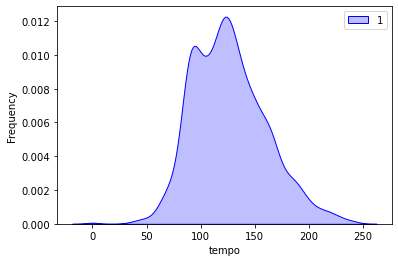

In [10]:
freq("tempo")

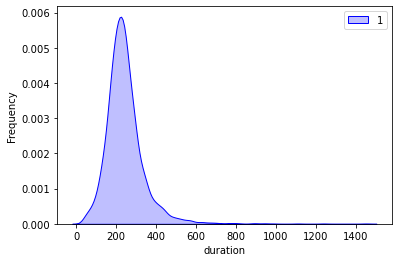

In [11]:
freq("duration")

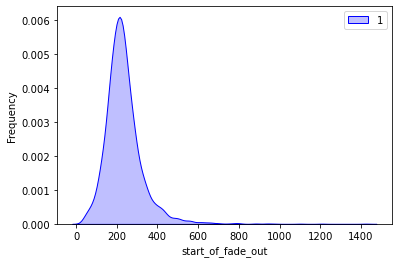

In [12]:
freq("start_of_fade_out")

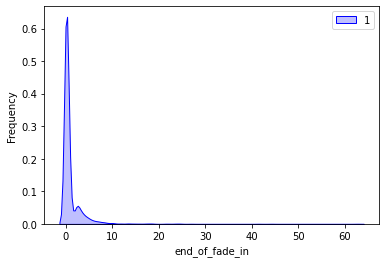

In [13]:
freq("end_of_fade_in")

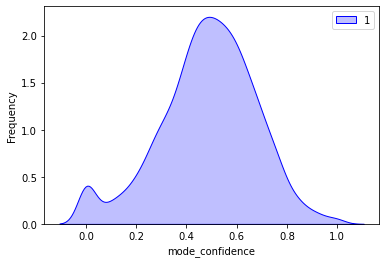

In [14]:
freq("mode_confidence")

In [15]:
# Se quisermos delimitar o tamanho do DF para rodar mais rápido
# data = data[:10000]
# data.info()

In [16]:
country_cols = [col for col in data.columns if 'artist_country_code' in col]
interesting_cols = [
    "artist_familiarity",
    "artist_hotttnesss",
    "artist_id",
    "year",
    "time_signature",
    "duration",
    "key",
    "tempo",
    "mode",
    "mode_confidence",
    "time_signature_confidence",
    "end_of_fade_in",
    "loudness",
    "start_of_fade_out",
    "key_confidence",
    "song_hotttnesss",
] + country_cols

drop_list = [col for col in data.columns if col not in interesting_cols]
drop_list

['analysis_sample_rate',
 'artist_7digitalid',
 'artist_latitude',
 'artist_location',
 'artist_longitude',
 'artist_mbid',
 'artist_mbtags',
 'artist_mbtags_count',
 'artist_name',
 'artist_playmeid',
 'artist_terms',
 'artist_terms_freq',
 'artist_terms_weight',
 'audio_md5',
 'bars_confidence',
 'bars_start',
 'beats_confidence',
 'beats_start',
 'danceability',
 'energy',
 'release',
 'release_7digitalid',
 'sections_confidence',
 'sections_start',
 'segments_confidence',
 'segments_loudness_max',
 'segments_loudness_max_time',
 'segments_loudness_start',
 'segments_pitches',
 'segments_start',
 'segments_timbre',
 'similar_artists',
 'song_id',
 'tatums_confidence',
 'tatums_start',
 'title',
 'track_7digitalid',
 'track_id']

In [17]:
data = data.drop(data[data["song_hotttnesss"] == 0].sample(frac=.62236).index)

In [18]:
train = data.drop(drop_list, axis=1)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 19998
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_familiarity         10000 non-null  float64
 1   artist_hotttnesss          10000 non-null  float64
 2   artist_id                  10000 non-null  int64  
 3   duration                   10000 non-null  float64
 4   end_of_fade_in             10000 non-null  float64
 5   key                        10000 non-null  int32  
 6   key_confidence             10000 non-null  float64
 7   loudness                   10000 non-null  float64
 8   mode                       10000 non-null  int32  
 9   mode_confidence            10000 non-null  float64
 10  song_hotttnesss            10000 non-null  int64  
 11  start_of_fade_out          10000 non-null  float64
 12  tempo                      10000 non-null  float64
 13  time_signature             10000 non-null  int

In [20]:
print("N. classe não hit: ")
print( len(data[data["song_hotttnesss"]==0]) )


print("N. classe hit: ")
print( len(data[data["song_hotttnesss"]==1]) )

N. classe não hit: 
5000
N. classe hit: 
5000


In [21]:
Y = copy.deepcopy(train.song_hotttnesss)
Y.shape

(10000,)

In [22]:
train1 = train.drop("song_hotttnesss", axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train1, Y, test_size=0.20, random_state=7)

In [24]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Fazer previsões para os dados de teste
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {round(accuracy * 100, 2,)}%")


Accuracy: 73.6%


In [25]:
# Função para avaliar o modelo com Cross validation >> resultado em AUC
def test_model_AUC(model, X_train, Y_train):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring = "roc_auc")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [26]:
# Função para avaliar o modelo com Cross validation >> resultado em ACCURACY
def test_model_accuracy(model, X_train, Y_train):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring = "accuracy")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

In [27]:
# AUC 81.84%
# ACC 74.82%
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(train1, Y)
auc_random_forest = test_model_AUC(rf, train1, Y)
print(f"AUC: {round(auc_random_forest*100,2,)}%")
acc_random_forest = test_model_accuracy(rf, train1, Y)
print(f"Accuracy: {round(acc_random_forest*100,2,)}%")

Scores: [0.79688  0.793646 0.801214 0.800798 0.832418 0.7848   0.806022 0.816248
 0.791302 0.839084]
Mean: 0.8062412
Standard Deviation: 0.01687641998055274
AUC: 80.62%
Scores: [0.724 0.714 0.736 0.739 0.746 0.714 0.732 0.737 0.722 0.755]
Mean: 0.7319
Standard Deviation: 0.012754999019992132
Accuracy: 73.19%


In [28]:
# AUC 83.29%
# ACC 75.76%
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    nthread=4,
    scale_pos_weight=1,
    seed=0,
)
xgb1.fit(train1, Y)
auc_xgb = test_model_AUC(xgb1, train1, Y)
print(f"AUC: {round(auc_xgb * 100,2,)}%")
acc_xgb = test_model_accuracy(xgb1, train1, Y)
print(f"Accuracy: {round(acc_xgb * 100,2,)}%")

Scores: [0.822996 0.814232 0.822856 0.815816 0.852012 0.810496 0.8351   0.828976
 0.804004 0.849892]
Mean: 0.825638
Standard Deviation: 0.01524176632808679
AUC: 82.56%
Scores: [0.746 0.738 0.74  0.759 0.781 0.737 0.762 0.75  0.737 0.773]
Mean: 0.7523
Standard Deviation: 0.015033628969746473
Accuracy: 75.23%


In [29]:
# AUC 62.45%
# ACC 59.21%
logreg = LogisticRegression()

logreg.fit(train1, Y)

auc_log = test_model_AUC(logreg, train1, Y)
print(f"AUC: {round(auc_log*100,2,)}%")
acc_log = test_model_accuracy(logreg, train1, Y)
print(f"Accuracy: {round(acc_log*100,2,)}%")

/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Scores: [0.60968  0.62778  0.582152 0.592584 0.61006  0.592164 0.59694  0.639808
 0.604012 0.617804]
Mean: 0.6072984
Standard Deviation: 0.01672135776305261
AUC: 60.73%


/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Scores: [0.587 0.606 0.556 0.582 0.574 0.56  0.58  0.602 0.584 0.594]
Mean: 0.5825
Standard Deviation: 0.015409412707822428
Accuracy: 58.25%


/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [30]:
# AUC 56.08%
# ACC 54.80%
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(train1, Y)

auc_knn = test_model_AUC(knn, train1, Y)
print(f"AUC: {round(auc_knn*100,2,)}%")
acc_knn = test_model_accuracy(knn, train1, Y)
print(f"Accuracy: {round(acc_knn*100,2,)}%")

Scores: [0.562288 0.565396 0.555446 0.56372  0.571956 0.569662 0.578556 0.570892
 0.573694 0.601096]
Mean: 0.5712705999999999
Standard Deviation: 0.01172319352565673
AUC: 57.13%
Scores: [0.537 0.545 0.551 0.543 0.553 0.551 0.562 0.556 0.551 0.588]
Mean: 0.5537000000000001
Standard Deviation: 0.013198863587445684
Accuracy: 55.37%


In [31]:
# AUC 57.52%
# ACC 50.25%
linear_svc = LinearSVC()
linear_svc.fit(train1, Y)

auc_linear_svc = test_model_AUC(linear_svc, train1, Y)
print(f"AUC: {round(auc_linear_svc*100,2,)}%")

acc_linear_svc = test_model_accuracy(linear_svc, train1, Y)
print(f"Accuracy: {round(acc_linear_svc*100,2,)}%")

/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/sit

Scores: [0.593508 0.526044 0.5099   0.518736 0.561648 0.581556 0.530316 0.612016
 0.562684 0.543236]
Mean: 0.5539644
Standard Deviation: 0.032352211248073914
AUC: 55.4%


/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/sit

Scores: [0.518 0.5   0.5   0.499 0.501 0.5   0.5   0.5   0.499 0.5  ]
Mean: 0.5016999999999999
Standard Deviation: 0.005459853477887484
Accuracy: 50.17%


/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [32]:
# AUC 67.96%
# ACC 67.84%
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train1, Y)

auc_decision_tree = test_model_AUC(decision_tree, train1, Y)
print(f"AUC: {round(auc_decision_tree*100,2,)}%")

acc_decision_tree = test_model_accuracy(decision_tree, train1, Y)
print(f"Accuracy: {round(acc_decision_tree*100,2,)}%")

Scores: [0.663 0.682 0.684 0.662 0.686 0.663 0.699 0.68  0.661 0.701]
Mean: 0.6780999999999999
Standard Deviation: 0.014439182802361032
AUC: 67.81%
Scores: [0.675 0.686 0.682 0.672 0.689 0.663 0.681 0.679 0.678 0.699]
Mean: 0.6803999999999999
Standard Deviation: 0.009297311439335544
Accuracy: 68.04%


In [33]:
# AUC 52.13%
# ACC 50.29%
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
auc_sgd = test_model_AUC(sgd, train1, Y)  
print(f"AUC: {round(auc_sgd*100,2,)}%")
acc_sgd = test_model_accuracy(sgd, train1, Y)  
print(f"Accuracy: {round(acc_sgd*100,2,)}%")

Scores: [0.515636 0.527156 0.509044 0.50914  0.522188 0.488628 0.494972 0.543152
 0.518192 0.532164]
Mean: 0.5160272
Standard Deviation: 0.01566215931983839
AUC: 51.6%
Scores: [0.522 0.501 0.5   0.5   0.5   0.486 0.52  0.5   0.516 0.5  ]
Mean: 0.5045
Standard Deviation: 0.010651291001564091
Accuracy: 50.45%


In [34]:
results_auc = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'XGB', 
              'Decision Tree', "Stochastic Gradient Descent"],
    'AUC': [auc_linear_svc, auc_knn, auc_log, 
              auc_random_forest, auc_xgb, 
             auc_decision_tree, auc_sgd]})
result_df = results_auc.sort_values(by='AUC', ascending=False)
result_df = result_df.set_index('AUC')
result_df.head(7)

,Model
AUC,
0.825638,XGB
0.806241,Random Forest
0.678100,Decision Tree
0.607298,Logistic Regression
0.571271,KNN
0.553964,Support Vector Machines
0.516027,Stochastic Gradient Descent


In [35]:
results_acc = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'XGB', 
              'Decision Tree', "Stochastic Gradient Descent"],
    'Accuracy': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_xgb, 
             acc_decision_tree, acc_sgd]})
result_df = results_acc.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Accuracy')
result_df.head(7)

,Model
Accuracy,
0.7523,XGB
0.7319,Random Forest
0.6804,Decision Tree
0.5825,Logistic Regression
0.5537,KNN
0.5045,Stochastic Gradient Descent
0.5017,Support Vector Machines


In [36]:
# instantiate the model
log_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgb = XGBClassifier()

# fit the model using the training data
log_regression.fit(X_train,y_train)
decision_tree.fit(X_train,y_train)
random_forest.fit(X_train,y_train)
xgb.fit(X_train,y_train)

/Users/henriquelaguardia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [37]:
from sklearn.metrics import roc_curve

# roc curve for models
y_pred_proba_1 = log_regression.predict_proba(X_test)[::,1]
fpr1, tpr1, thresh1 = roc_curve(y_test,  y_pred_proba_1)

y_pred_proba_2 = decision_tree.predict_proba(X_test)[::,1]
fpr2, tpr2, thresh2 = roc_curve(y_test,  y_pred_proba_2)

y_pred_proba_3 = random_forest.predict_proba(X_test)[::,1]
fpr3, tpr3, thresh3 = roc_curve(y_test,  y_pred_proba_3)

y_pred_proba_4 = xgb.predict_proba(X_test)[::,1]
fpr4, tpr4, thresh4 = roc_curve(y_test,  y_pred_proba_4)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

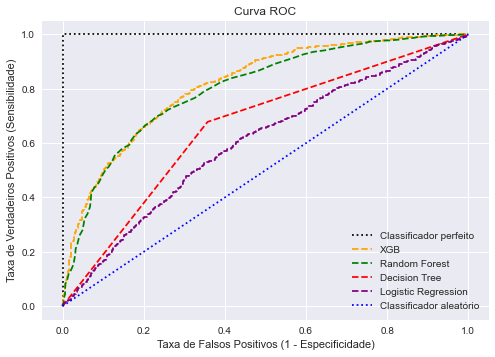

In [38]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Classificador perfeito')
plt.plot(fpr4, tpr4, linestyle='--',color='orange', label='XGB')
plt.plot(fpr3, tpr3, linestyle='--',color='green', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='Decision Tree')
plt.plot(fpr1, tpr1, linestyle='--',color='purple', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle=':', color='blue', label = 'Classificador aleatório')
# title
plt.title('Curva ROC')
# x label
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
# y label
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')

plt.legend(loc='lower right')
plt.savefig('ROC',dpi=300)
plt.show();